In [1]:
from experiments_frugality import *

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.5.1 available.


In [2]:
std_noise_train = 0.05
std_noise = 0.05
components_list = [2, 10, 50] #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
layers_list = [1, 20] #[1, 20]
n_rep_list = [1, 2, 3, 4, 5, 10, 20, 100, 1000] #[1, 20, 50, 100]
denoiser_type_list = ["SD"] #, "SD"]
pth_kernel = "blur_models/blur_3.mat" #"blur_models/blur_1.mat"
img_list = [0] #, 4]
n_iter_per_lambda = 200
n_lambda = 50
lambda_start = 10
lambda_end = 1e-5
eps_stop = 1e-6
warm_restart = True
save_path = "experiments/gloubiboulga/results.pkl"

params_model = {
        "kernel_size": 5,
        "lmbd": 1e-4,
        "color": COLOR,
        "device": DEVICE,
        "dtype": torch.float,
        "optimizer": "adam",
        "path_data": DATA_PATH,
        "max_sigma_noise": std_noise_train,
        "min_sigma_noise": std_noise_train,
        "mini_batch_size": 1,
        "max_batch": 10,
        "epochs": 50,
        "avg": False,
        "rescale": False,
        "fixed_noise": True,
        "D_shared": True,
        "step_size_scaling": 1.8,
        "lr": 1e-3,
        "dataset": DATASET,
    }

In [3]:
T_START = time.time()

DENOISERS = {"DRUNet": dict(model="drunet")}
DENOISERS["DRUNet"]["net"] = get_denoiser(**DENOISERS["DRUNet"])

for denoiser_type in denoiser_type_list:
    for components in components_list:
        for layers in layers_list:
            params = {k: v for k, v in params_model.items()}
            params["n_layers"] = layers
            params["n_components"] = components
            
            # ----- #REPEAT = #LAYERS -----
            if denoiser_type == "SD":
                base_name = f"SD_{components}C_{layers}L"
                model_type = "synthesis"
            elif denoiser_type == "AD":
                base_name = f"AD_{components}C_{layers}L"
                model_type = "analysis"
            
            name = f"{base_name}_{layers}R"
            DENOISERS[name] = {"model": model_type, **params}
            print(f"Training {base_name}...")
            DENOISERS[name]["net"] = get_denoiser(**DENOISERS[name])
            
            # ----- #REPEAT = 1 -----
            if layers > 1:
                denoiser = DENOISERS[name]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                # Replace the model with only the first layer of the trained model
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]])
                DENOISERS[f"{base_name}_1R"] = dict(net=net, model=denoiser["model"], **params)
                DENOISERS[f"{base_name}_1R"]["n_layers"] = 1
            
            # ----- #REPEAT = N_REP -----
            for n_rep in n_rep_list:
                if n_rep == layers:
                    continue
                denoiser = DENOISERS[f"{base_name}_1R"]
                old_net = denoiser["net"]
                net = UnrolledCDL(
                    type_unrolling=denoiser["model"],
                    **{k: v for k, v in denoiser.items() if k not in ["model", "net"]}
                ).unrolled_net
                assert len(net.model) == 1
                net.parameter = old_net.parameter
                net.model = torch.nn.ModuleList([old_net.model[0]] * n_rep)
                DENOISERS[f"{base_name}_{n_rep}R"] = dict(
                    net=net, model=denoiser["model"], **params
                )
                DENOISERS[f"{base_name}_{n_rep}R"]["n_layers"] = n_rep

print(f"\nSuccessfully prepared {len(DENOISERS.keys())} denoisers in {time.time() - T_START:.2f} seconds.")

Training SD_2C_1L...


Epoch 50 - Average train loss: 0.06937405 - Average test loss: 0.06452079: 100%|██████████| 50/50 [00:03<00:00, 14.41it/s]


Done
Training SD_2C_20L...


Epoch 50 - Average train loss: 0.01335679 - Average test loss: 0.01262356: 100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Done
Training SD_10C_1L...


Epoch 50 - Average train loss: 0.06480838 - Average test loss: 0.06009800: 100%|██████████| 50/50 [00:02<00:00, 18.79it/s]


Done
Training SD_10C_20L...


Epoch 50 - Average train loss: 0.00269176 - Average test loss: 0.00261558: 100%|██████████| 50/50 [00:08<00:00,  5.71it/s]


Done
Training SD_50C_1L...


Epoch 50 - Average train loss: 0.06321905 - Average test loss: 0.05791021: 100%|██████████| 50/50 [00:02<00:00, 18.26it/s]


Done
Training SD_50C_20L...


Epoch 50 - Average train loss: 0.00167074 - Average test loss: 0.00162557: 100%|██████████| 50/50 [00:14<00:00,  3.34it/s]

Done

Successfully prepared 55 denoisers in 41.83 seconds.


In [4]:
dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=std_noise,
    max_sigma_noise=std_noise,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

In [5]:
img = dataloader.dataset[img_list[0]][1].cpu().numpy()
x_truth = img

h = scipy.io.loadmat(pth_kernel)
h = np.array(h["blur"])

Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
x_blurred = Phi_channels(img, Phi)
nc, nxb, nyb = x_blurred.shape
x_observed = x_blurred + std_noise * np.random.randn(nc, nxb, nyb)
normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
gamma = 1.0 / normPhi2

In [6]:
results = {
    "observation": x_observed,
    "truth": img
}

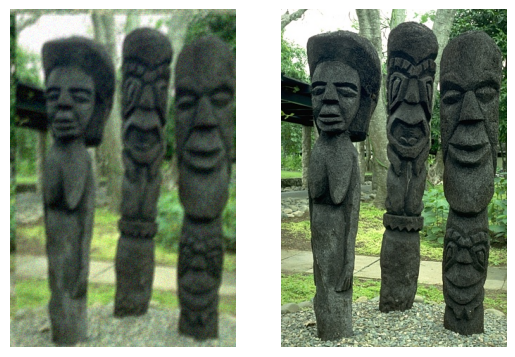

PSNR: 14.38 dB


/tmp/ipykernel_4469/2873729282.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print(f"PSNR: {peak_signal_noise_ratio(x_truth, x_observed.clip(0, 1)):.2f} dB")


In [7]:
def show_imgs(list_img, figsize=None, two_d=False):
    plt.figure(figsize=figsize)
    for i, img in enumerate(list_img):
        plt.subplot(1, len(list_img), i + 1)
        if two_d:
            img = img.squeeze()
        else:
            img = img.transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

show_imgs([x_observed.clip(0,1), x_truth])
print(f"PSNR: {peak_signal_noise_ratio(x_truth, x_observed.clip(0, 1)):.2f} dB")

### Synthesis

In [133]:
denoiser_names = ["SD_10C_1L_1R", "SD_10C_1L_20R", "SD_10C_1L_100R"]


Running denoiser: SD_10C_1L_1R
lambda_max: 5.470734596252441


100%|██████████| 50/50 [01:58<00:00,  2.37s/it]


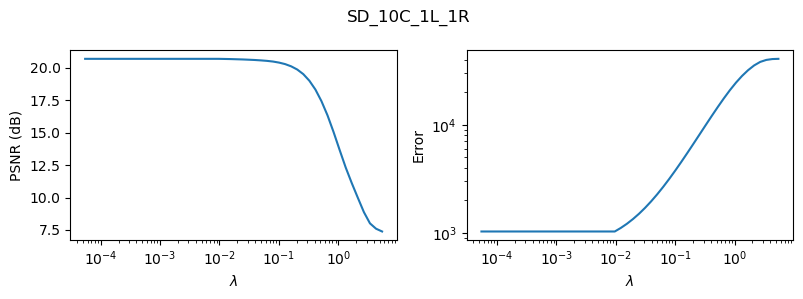

100%|██████████| 1000/1000 [01:19<00:00, 12.63it/s]


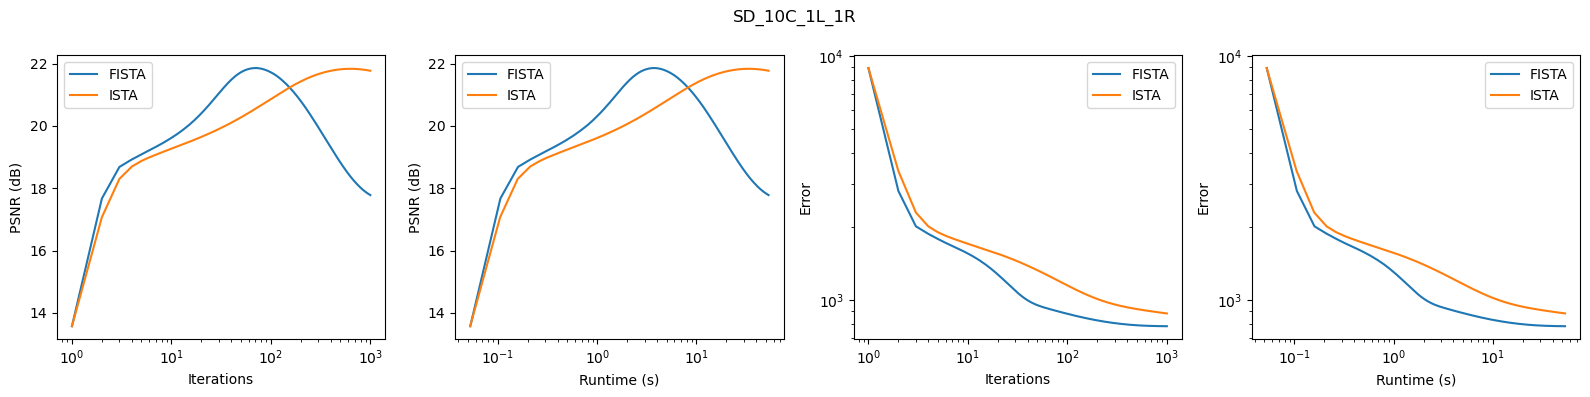


Running denoiser: SD_10C_1L_20R
lambda_max: 5.470734596252441


100%|██████████| 50/50 [03:42<00:00,  4.44s/it]


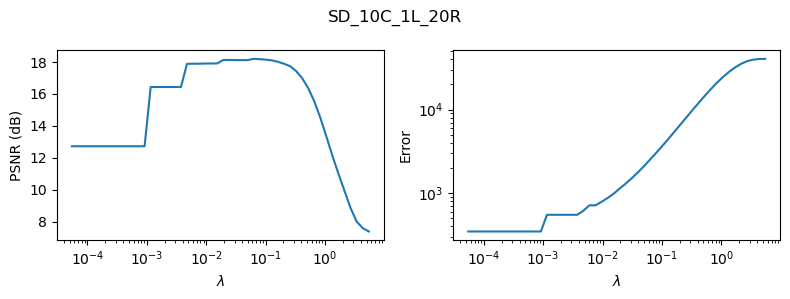

100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


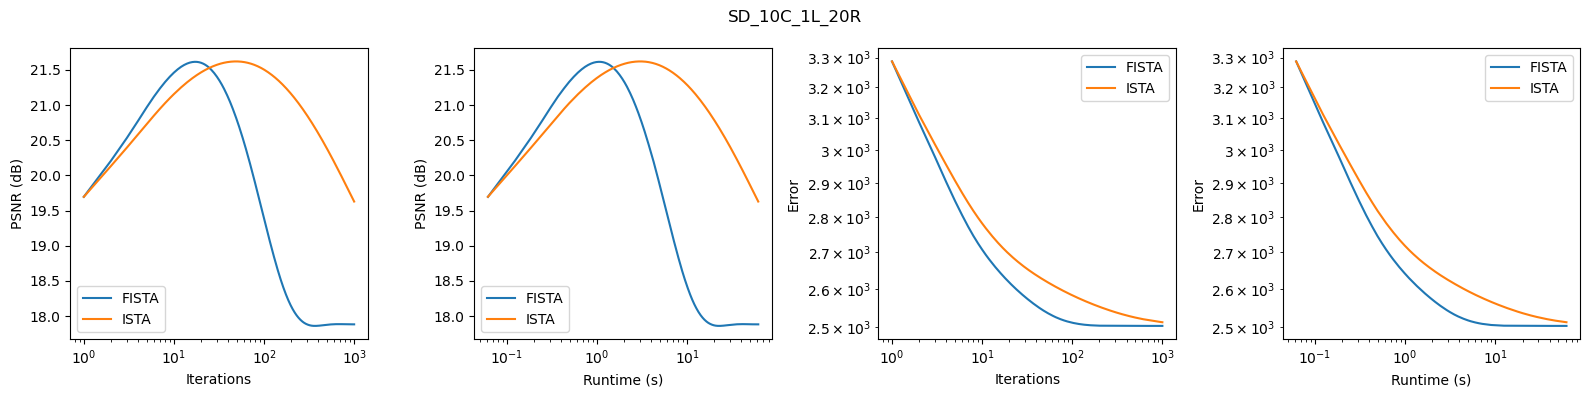


Running denoiser: SD_10C_1L_100R
lambda_max: 5.470734596252441


100%|██████████| 50/50 [05:07<00:00,  6.15s/it]


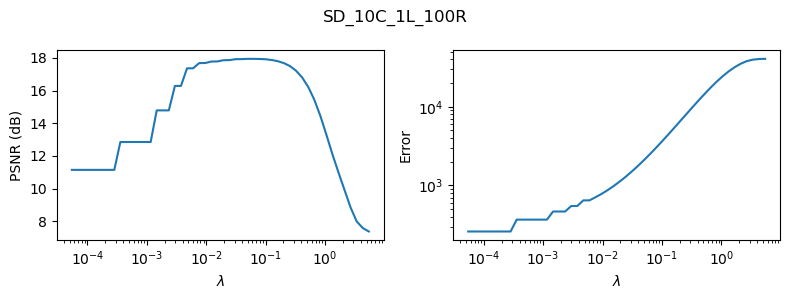

100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]


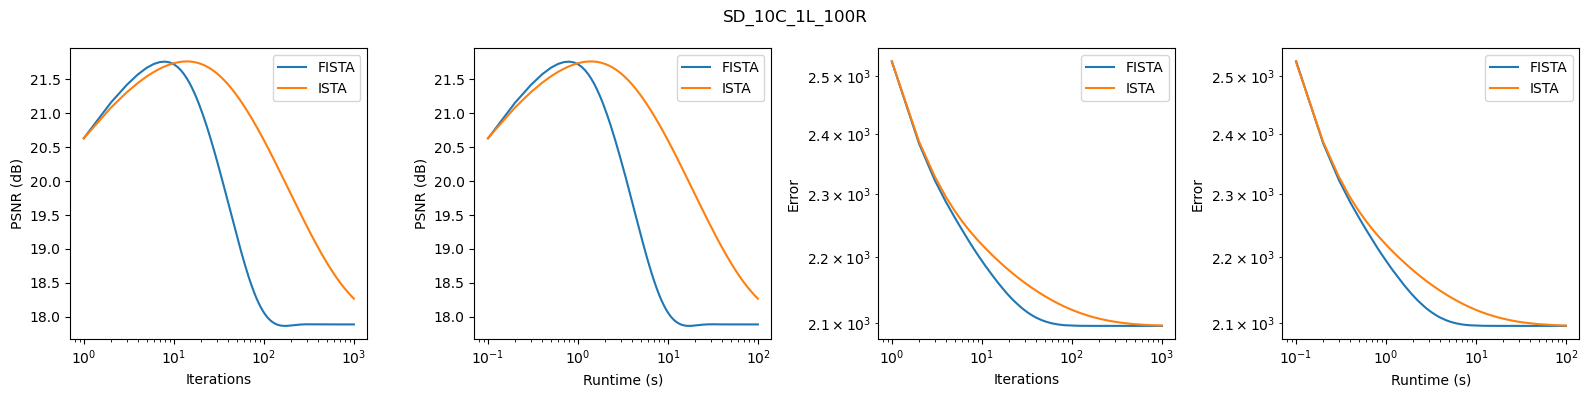

In [146]:
eps_stop = 5e-7

for denoiser_name in denoiser_names:
    
    print(f"\nRunning denoiser: {denoiser_name}")

    denoiser = DENOISERS[denoiser_name]
    net = denoiser["net"]
    model = "unrolled"
    model_type = denoiser["model"]

    lambda_max = lambda_max_synthesis(x_observed, denoiser["net"], Phit)
    lambda_list = np.logspace(np.log10(1*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
    n_iter_per_lambda = 200

    n_lambda = len(lambda_list)
    if lambda_list is None:
        lambda_list = [0.5 * std_noise] * n_lambda

    x_n = Phi_channels(x_observed, Phit)
    best_x_psnr = x_n.copy()
    best_x_error = x_n.copy()
    best_psnr = 0
    best_error = 0
    best_lambda = 0

    cvg = [1e10] * n_lambda*n_iter_per_lambda
    psnr = [0] * n_lambda
    error = [0] * n_lambda
    psnr_inner = [0] * n_lambda*n_iter_per_lambda
    error_inner = [0] * n_lambda*n_iter_per_lambda
    runtime = [0] * n_lambda*n_iter_per_lambda
    stops = [0] * (n_lambda+1)

    current_dual = None
    current_dual_fast = None

    best_current_dual, best_current_dual_fast = None, None

    t_iter = 0

    i = 0
    for k in tqdm(range(n_lambda)):
        if not warm_restart:
            x_n = Phi_channels(x_observed, Phit)
            current_dual = None
            current_dual_fast = None
        
        for t in range(n_iter_per_lambda):
            t_start = time.perf_counter()
            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            x_old = x_n.copy()

            if model_type != "synthesis":
                x_n, current_dual = apply_model(
                    model, tmp, current_dual, lambda_list[k], net, True
                )
            else:
                alpha = t/(t+4)
                #alpha = 0
                x_n, current_dual, current_dual_fast = apply_model(
                    model, tmp, current_dual, lambda_list[k], net, True,
                    fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
                )
            
            t_iter += time.perf_counter() - t_start
            cvg[i] = np.sum((x_n - x_old) ** 2)
            runtime[i] = t_iter
            psnr_inner[i] = peak_signal_noise_ratio(x_n, x_truth)
            criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            
            if model_type == "analysis":
                error_inner[i] = error_analysis(x_n, x_observed, net, Phi, lambda_list[k])
            elif model_type == "synthesis":
                error_inner[i] = error_synthesis(current_dual[0], x_observed, net, Phi, lambda_list[k])
                
            if eps_stop is not None and criterion < eps_stop:
                break
            i += 1
        
        stops[k+1] = i
        
        if x_truth is not None:
            psnr[k] = psnr_inner[i-1]
            error[k] = error_inner[i-1]
            if psnr[k] > best_psnr:
                best_psnr = psnr[k]
                best_x_psnr = x_n.copy()
                best_lambda = lambda_list[k]
                best_current_dual = current_dual.copy() if current_dual is not None else None
                best_current_dual_fast = current_dual_fast.copy() if current_dual_fast is not None else None
            if error[k] < best_error:
                best_error = error[k]
                best_x_error = x_n.copy()
    
    # Plot PSNR vs lambda and error vs lambda on 2 subplots
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.semilogx(lambda_list, psnr)
    plt.xlabel(r"$\lambda$")
    plt.ylabel("PSNR (dB)")
    
    plt.subplot(1, 2, 2)
    plt.loglog(lambda_list, error)
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Error")
    plt.suptitle(f"{denoiser_name}")
    plt.tight_layout()
    plt.show()
    
    x_n = Phi_channels(x_observed, Phit)
    current_dual = None
    current_dual_fast = None

    iter_final = 1000
    error_final = [0] * iter_final
    psnr_final = [0] * iter_final
    best_psnr = 0
    runtime_final = [0] * iter_final
    cvg_final = [0] * iter_final
    t_iter = 0
    update_dual = True

    for t in tqdm(range(iter_final)):
        
        t_start = time.perf_counter()

        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        
        
        x_old = x_n.copy()
        alpha = t/(t+4)
        #alpha = 0
        x_n, current_dual, current_dual_fast = apply_model(
            model, tmp, current_dual, best_lambda, net, update_dual,
            fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
        )

        t_iter += time.perf_counter() - t_start
        runtime_final[t] = t_iter
        cvg_final[t] = np.sum((x_n - x_old) ** 2)
        psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
        error_final[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
        
        if psnr_final[t] > best_psnr:
            best_x = x_n.copy()
            best_dual = current_dual.copy()
            best_psnr = psnr_final[t]

    x_n = Phi_channels(x_observed, Phit)
    current_dual = None
    current_dual_fast = None

    error_final_ista = [0] * iter_final
    psnr_final_ista = [0] * iter_final
    best_psnr_ista = 0
    runtime_final_ista = [0] * iter_final
    cvg_final_ista = [0] * iter_final
    t_iter = 0
    update_dual = True

    for t in tqdm(range(iter_final)):
        
        t_start = time.perf_counter()

        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        
        
        x_old = x_n.copy()
        #alpha = t/(t+4)
        alpha = 0
        x_n, current_dual, current_dual_fast = apply_model(
            model, tmp, current_dual, best_lambda, net, update_dual,
            fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
        )

        t_iter += time.perf_counter() - t_start
        runtime_final_ista[t] = t_iter
        cvg_final_ista[t] = np.sum((x_n - x_old) ** 2)
        psnr_final_ista[t] = peak_signal_noise_ratio(x_n, x_truth)
        error_final_ista[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
        
        if psnr_final_ista[t] > best_psnr_ista:
            best_x_ista = x_n.copy()
            best_dual = current_dual.copy()
            best_psnr_ista = psnr_final_ista[t]

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.semilogx(np.arange(1, iter_final + 1), psnr_final, label="FISTA")
    plt.semilogx(np.arange(1, iter_final + 1), psnr_final_ista, label="ISTA")
    plt.xlabel("Iterations")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.semilogx(runtime_final, psnr_final, label="FISTA")
    plt.semilogx(runtime_final_ista, psnr_final_ista, label="ISTA")
    plt.xlabel("Runtime (s)")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.loglog(np.arange(1, iter_final + 1), error_final, label="FISTA")
    plt.loglog(np.arange(1, iter_final + 1), error_final_ista, label="ISTA")
    plt.xlabel("Iterations")
    plt.ylabel("Error")
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.loglog(runtime_final, error_final, label="FISTA")
    plt.loglog(runtime_final_ista, error_final_ista, label="ISTA")
    plt.xlabel("Runtime (s)")
    plt.ylabel("Error")
    plt.legend()

    plt.suptitle(f"{denoiser_name}")
    plt.tight_layout()
    plt.show()


Running denoiser: SD_10C_1L_1R


100%|██████████| 3/3 [07:43<00:00, 154.66s/it]


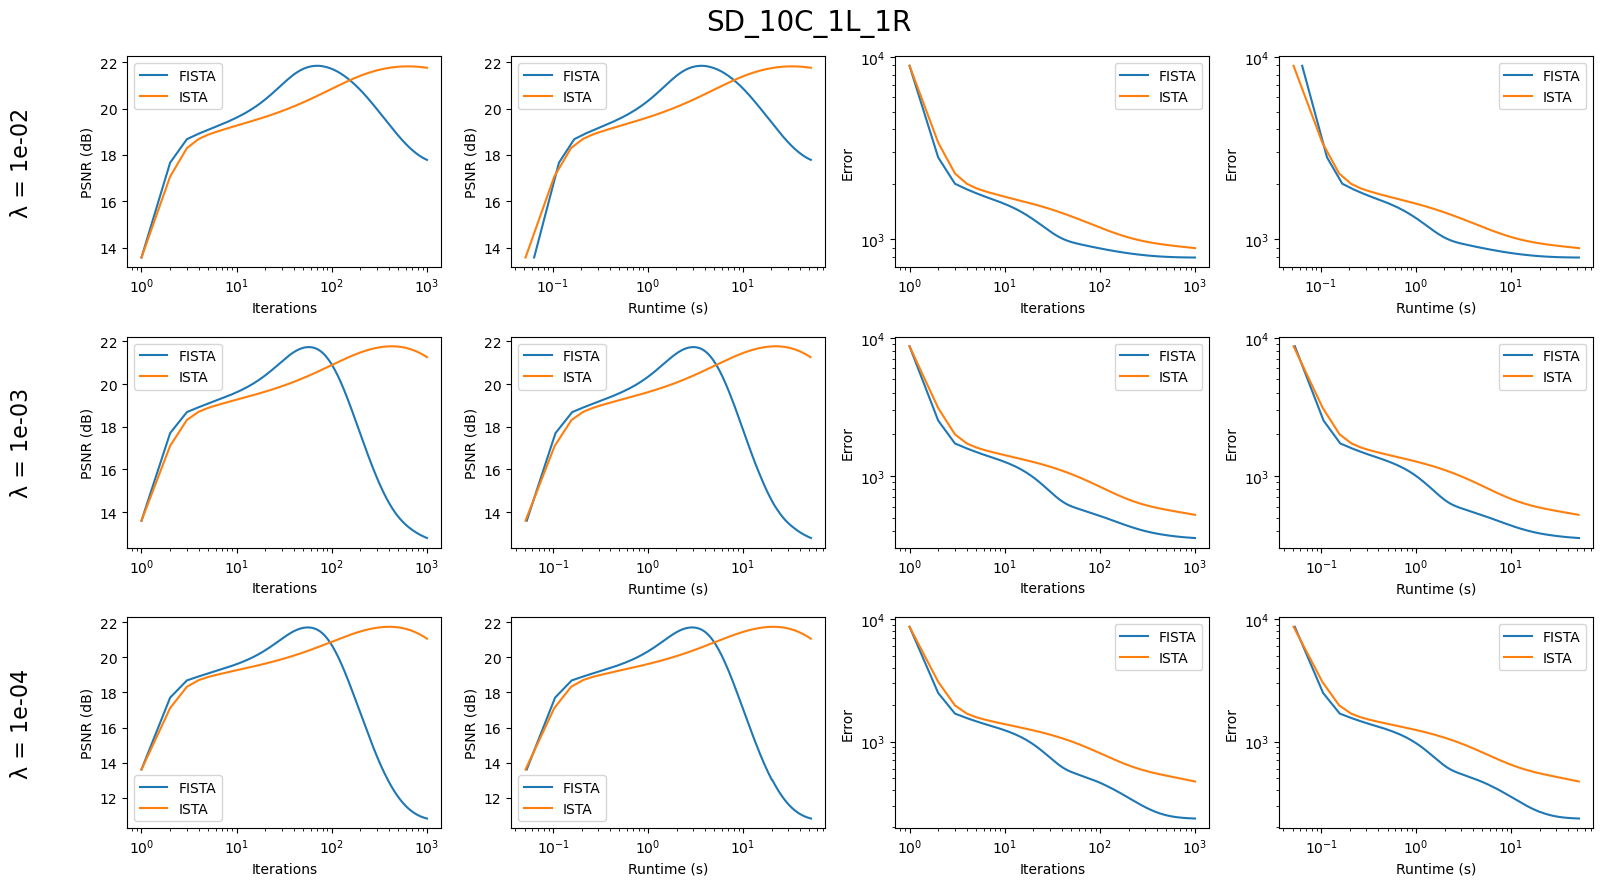


Running denoiser: SD_10C_1L_20R


100%|██████████| 3/3 [08:34<00:00, 171.44s/it]


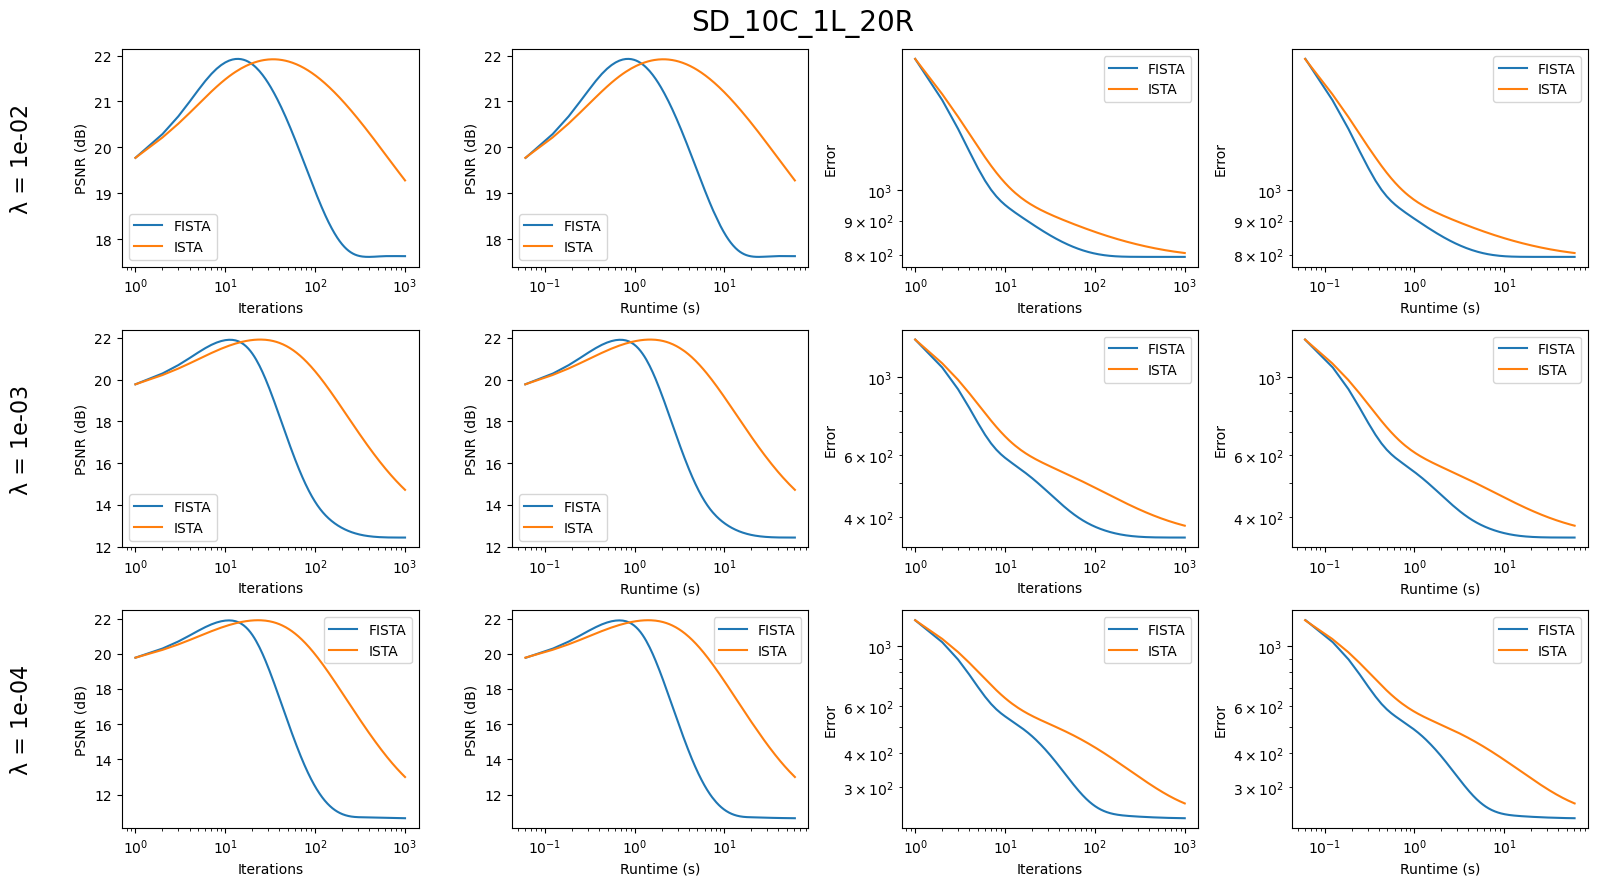


Running denoiser: SD_10C_1L_100R


100%|██████████| 3/3 [12:22<00:00, 247.58s/it]


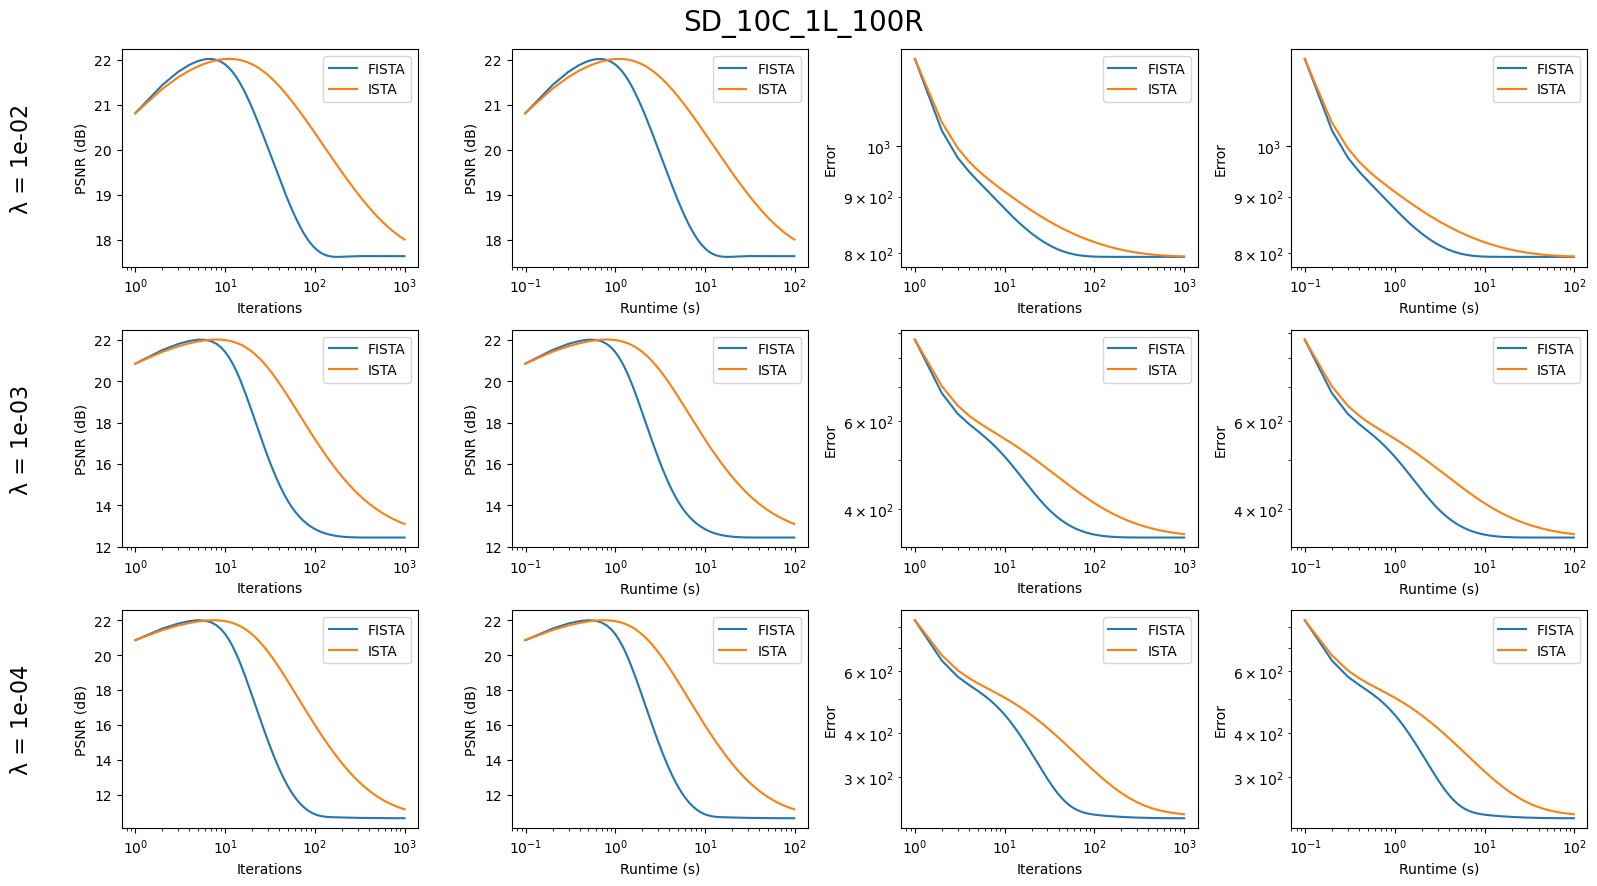

In [ ]:
for denoiser_name in denoiser_names:
    
    print(f"\nRunning denoiser: {denoiser_name}")

    denoiser = DENOISERS[denoiser_name]
    net = denoiser["net"]
    model = "unrolled"
    
    lambdas = [1e-2, 1e-3, 1e-4]
    n = len(lambdas)
    plt.figure(figsize=(16, 3*n))
    i = 0
    
    for best_lambda in tqdm(lambdas):
        
        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None

        iter_final = 1000
        error_final = [0] * iter_final
        psnr_final = [0] * iter_final
        best_psnr = 0
        runtime_final = [0] * iter_final
        cvg_final = [0] * iter_final
        t_iter = 0
        update_dual = True

        for t in range(iter_final):
            
            t_start = time.perf_counter()

            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            
            
            x_old = x_n.copy()
            alpha = t/(t+4)
            #alpha = 0
            x_n, current_dual, current_dual_fast = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual,
                fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
            )

            t_iter += time.perf_counter() - t_start
            runtime_final[t] = t_iter
            cvg_final[t] = np.sum((x_n - x_old) ** 2)
            psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
            error_final[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
            
            if psnr_final[t] > best_psnr:
                best_x = x_n.copy()
                best_dual = current_dual.copy()
                best_psnr = psnr_final[t]

        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None

        error_final_ista = [0] * iter_final
        psnr_final_ista = [0] * iter_final
        best_psnr_ista = 0
        runtime_final_ista = [0] * iter_final
        cvg_final_ista = [0] * iter_final
        t_iter = 0
        update_dual = True

        for t in range(iter_final):
            
            t_start = time.perf_counter()

            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            
            
            x_old = x_n.copy()
            #alpha = t/(t+4)
            alpha = 0
            x_n, current_dual, current_dual_fast = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual,
                fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
            )

            t_iter += time.perf_counter() - t_start
            runtime_final_ista[t] = t_iter
            cvg_final_ista[t] = np.sum((x_n - x_old) ** 2)
            psnr_final_ista[t] = peak_signal_noise_ratio(x_n, x_truth)
            error_final_ista[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
            
            if psnr_final_ista[t] > best_psnr_ista:
                best_x_ista = x_n.copy()
                best_dual = current_dual.copy()
                best_psnr_ista = psnr_final_ista[t]

        
        
        plt.subplot(n, 4, 4*i+1)
        
        plt.text(-0.3, 0.5, f"λ = {best_lambda:.0e}", fontsize=16,
                 transform=plt.gca().transAxes, rotation=90,
                 verticalalignment='center', horizontalalignment='right')
        
        plt.semilogx(np.arange(1, iter_final + 1), psnr_final, label="FISTA")
        plt.semilogx(np.arange(1, iter_final + 1), psnr_final_ista, label="ISTA")
        plt.xlabel("Iterations")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+2)
        plt.semilogx(runtime_final, psnr_final, label="FISTA")
        plt.semilogx(runtime_final_ista, psnr_final_ista, label="ISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+3)
        plt.loglog(np.arange(1, iter_final + 1), error_final, label="FISTA")
        plt.loglog(np.arange(1, iter_final + 1), error_final_ista, label="ISTA")
        plt.xlabel("Iterations")
        plt.ylabel("Error")
        plt.legend()

        plt.subplot(n, 4, 4*i+4)
        plt.loglog(runtime_final, error_final, label="FISTA")
        plt.loglog(runtime_final_ista, error_final_ista, label="ISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("Error")
        plt.legend()
        
        i += 1

    plt.suptitle(f"{denoiser_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

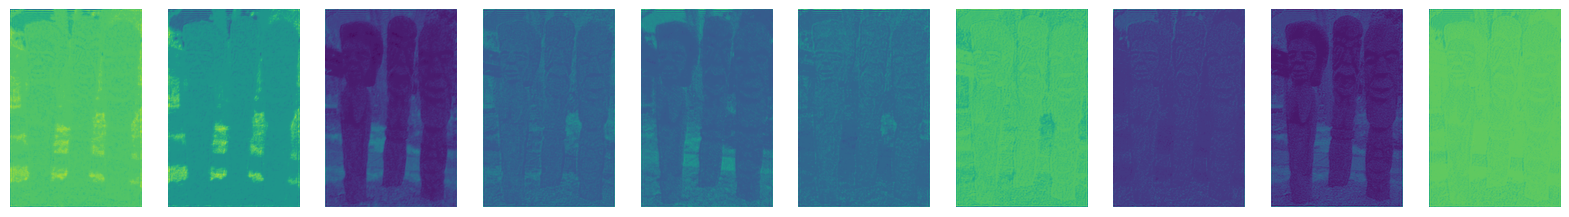

In [58]:
show_imgs([best_dual[0][i] for i in range(10)], two_d=True, figsize=(20, 10))

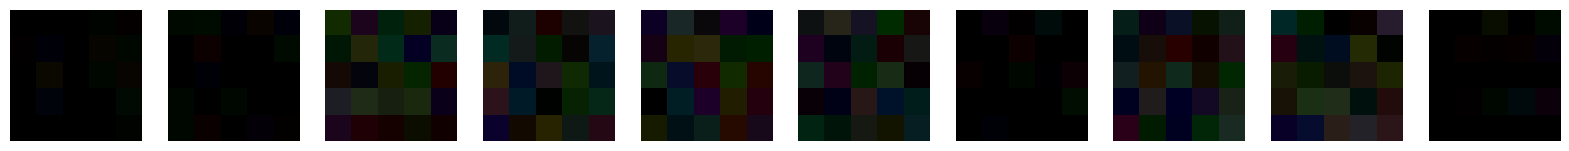

In [59]:
show_imgs([net.parameter[i].detach().cpu().numpy() for i in range(10)], figsize=(20, 20))

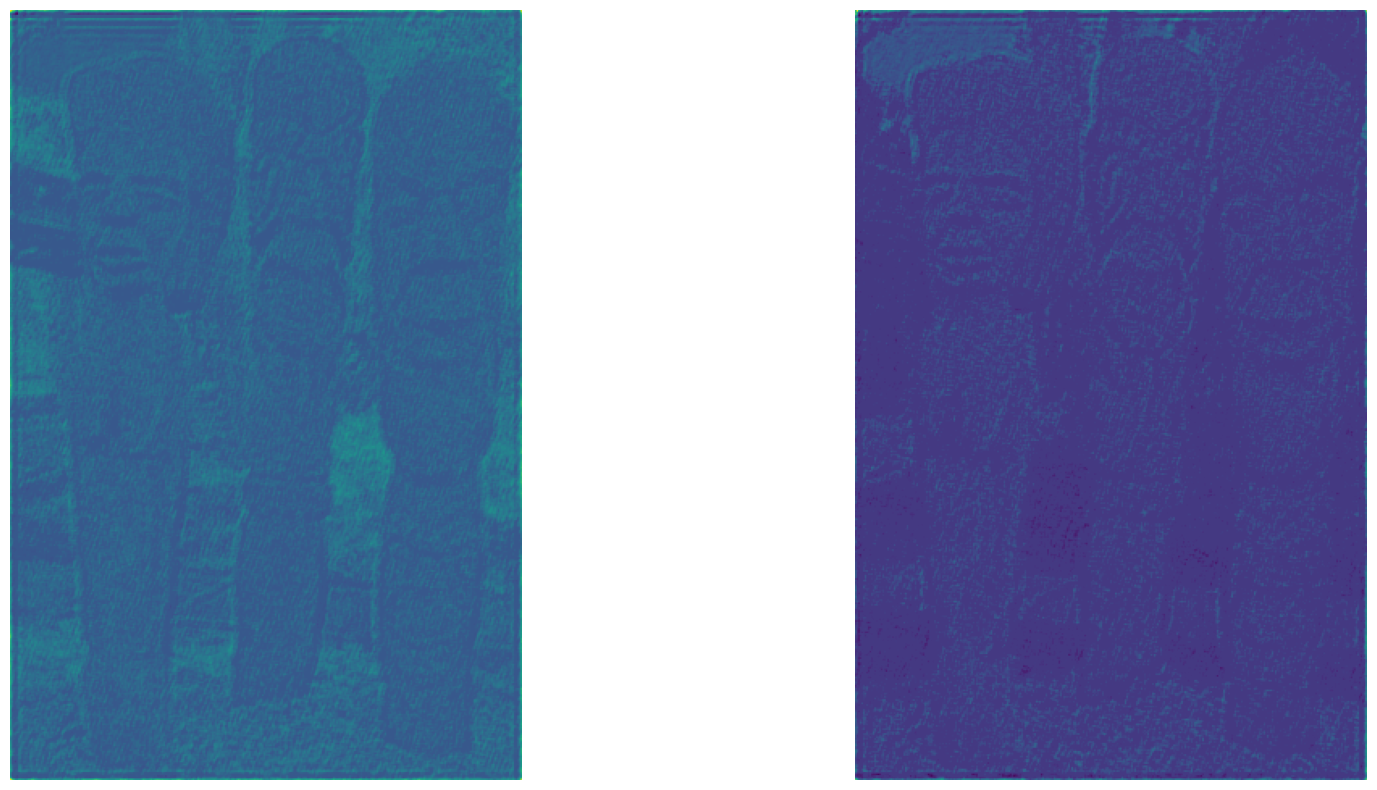

In [60]:
show_imgs([best_dual[0][3], best_dual[0][7]], two_d=True, figsize=(20, 10))

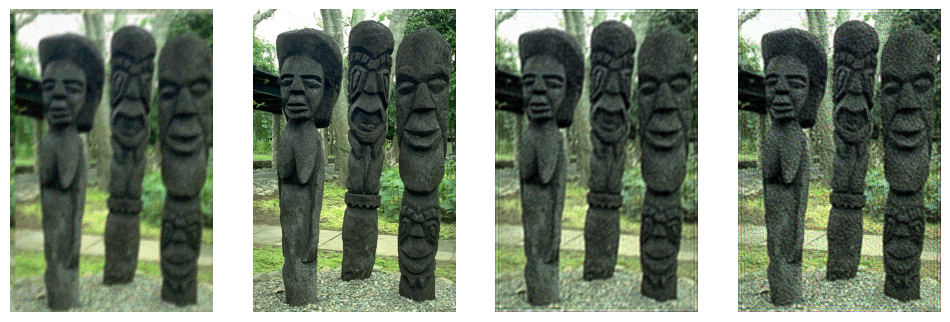

In [102]:
show_imgs([x_observed, x_truth, best_x, x_n], figsize=(12, 4))

### Synthesis more values of $L$

In [10]:
denoiser_names = [den for den in DENOISERS.keys() if den.split("_")[:-1] == ["SD", "10C", "1L"]]


Running denoiser: SD_10C_1L_1R


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:18<00:00, 12.82it/s]


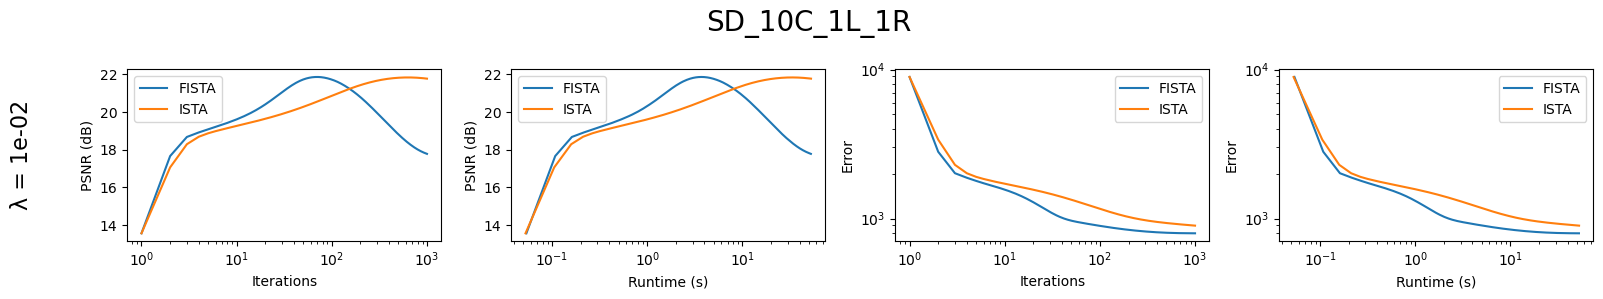


Running denoiser: SD_10C_1L_2R


100%|██████████| 1000/1000 [01:18<00:00, 12.79it/s]


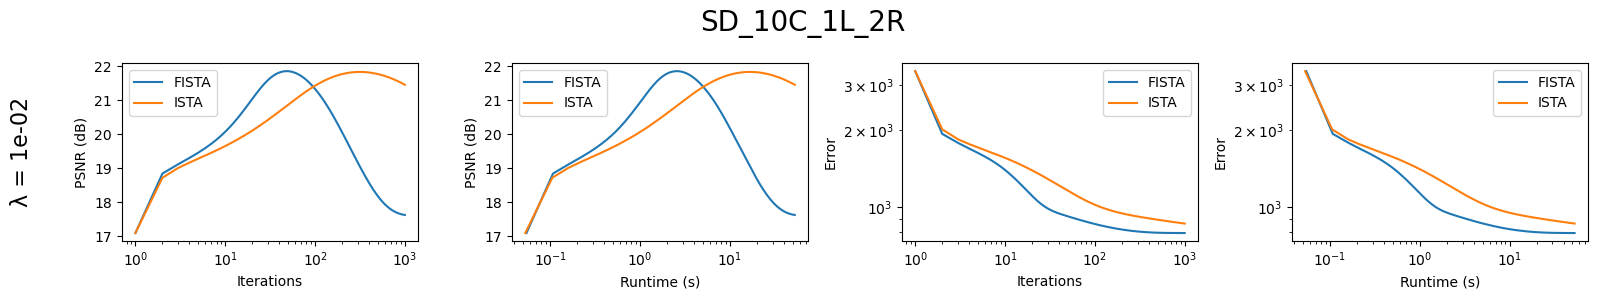


Running denoiser: SD_10C_1L_3R


100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


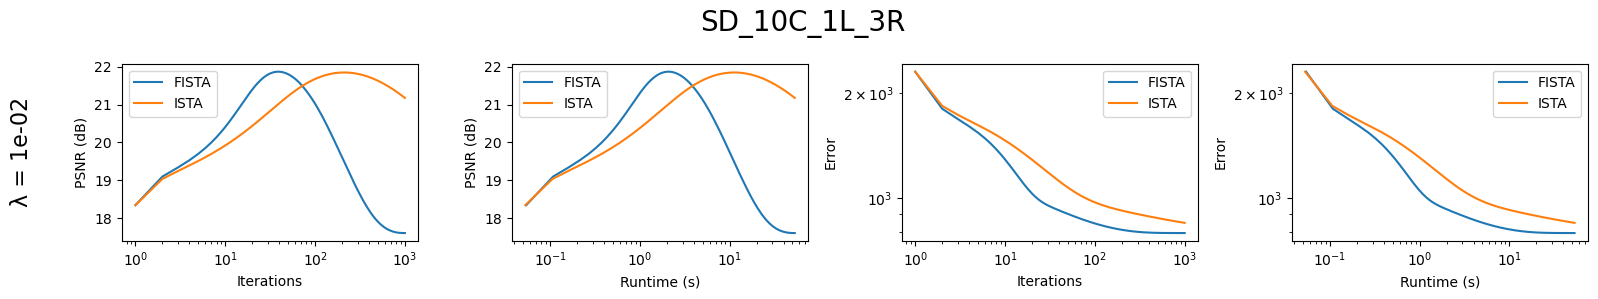


Running denoiser: SD_10C_1L_4R


100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s]


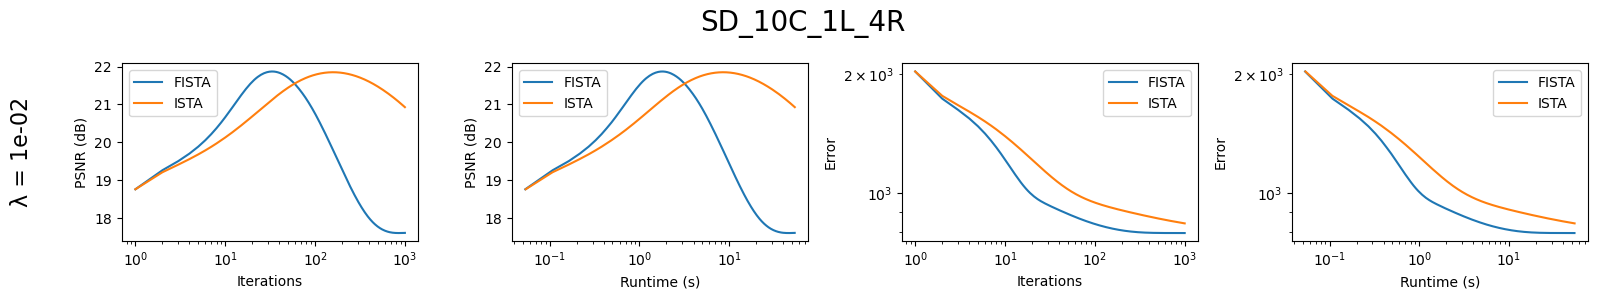


Running denoiser: SD_10C_1L_5R


100%|██████████| 1000/1000 [01:19<00:00, 12.59it/s]


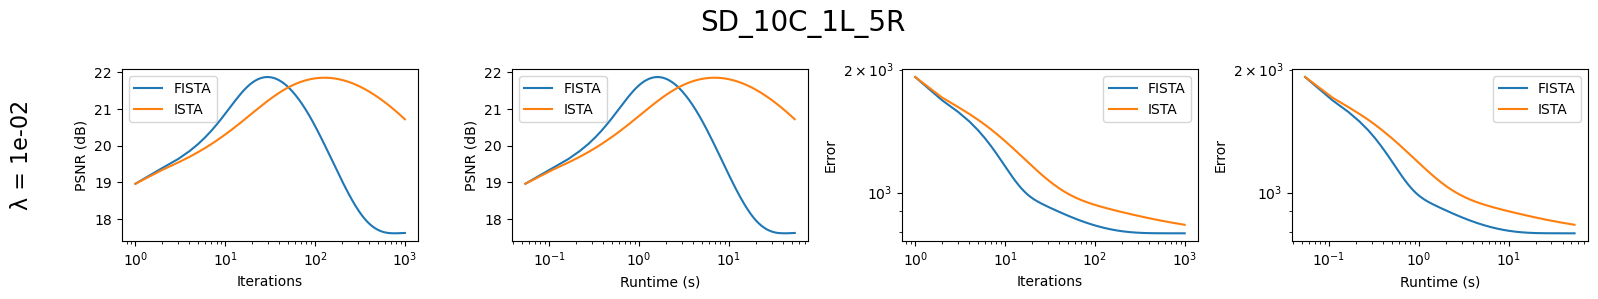


Running denoiser: SD_10C_1L_10R


100%|██████████| 1000/1000 [01:21<00:00, 12.20it/s]


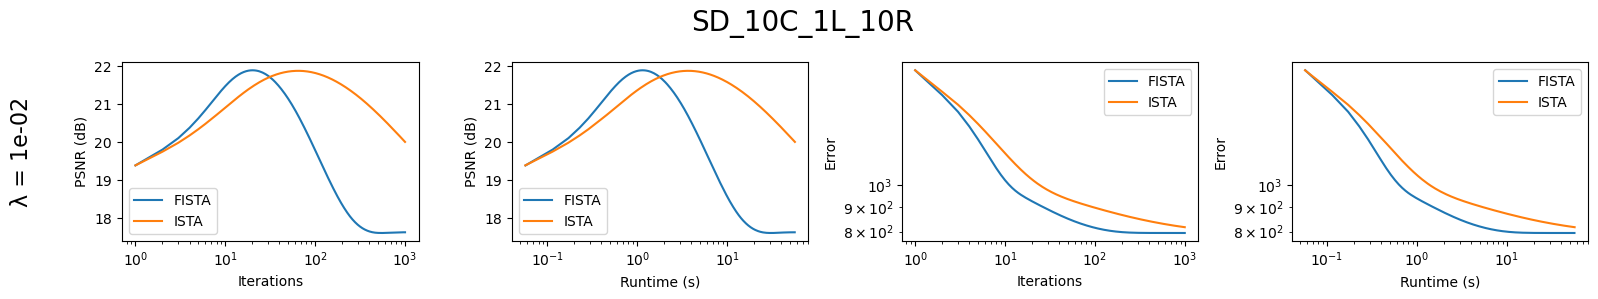


Running denoiser: SD_10C_1L_20R


100%|██████████| 1000/1000 [01:26<00:00, 11.59it/s]


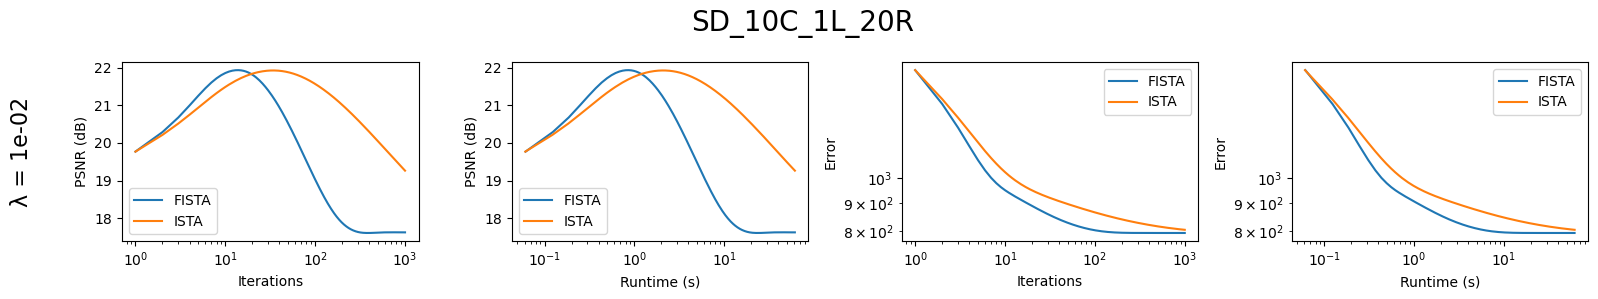


Running denoiser: SD_10C_1L_100R


100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


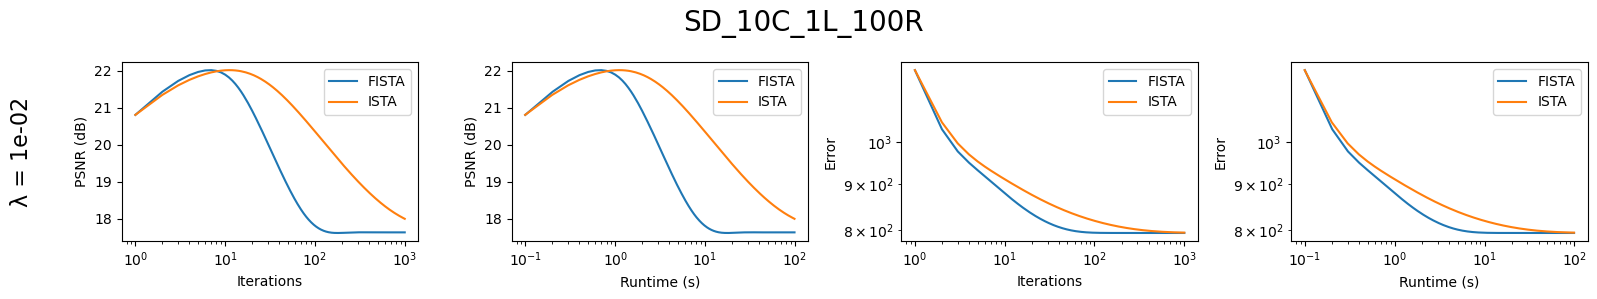


Running denoiser: SD_10C_1L_1000R


100%|██████████| 1000/1000 [09:09<00:00,  1.82it/s]


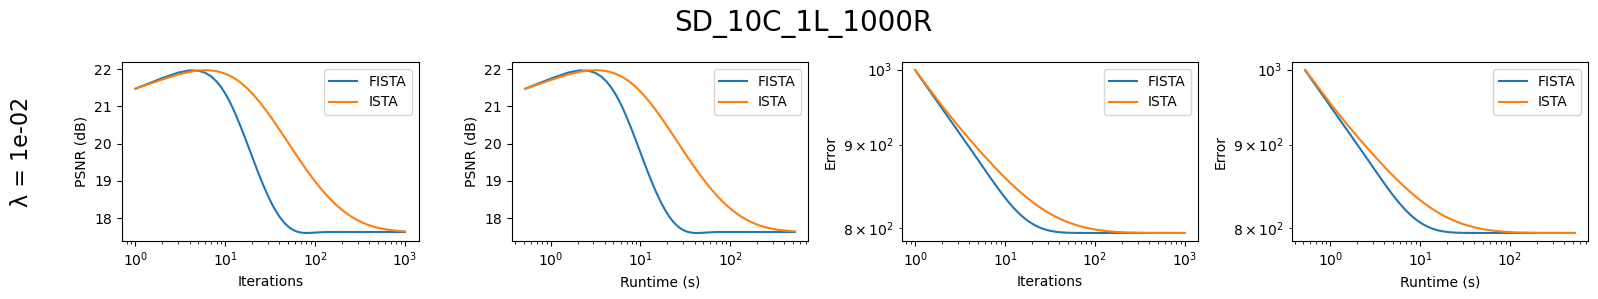

In [15]:
for denoiser_name in denoiser_names:
    
    print(f"\nRunning denoiser: {denoiser_name}")

    denoiser = DENOISERS[denoiser_name]
    net = denoiser["net"]
    model = "unrolled"
    
    lambdas = [1e-2] #, 1e-3, 1e-4]
    n = len(lambdas)
    plt.figure(figsize=(16, 3*n))
    i = 0
    
    for best_lambda in lambdas:
        
        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None

        iter_final = 1000
        error_final = [0] * iter_final
        psnr_final = [0] * iter_final
        best_psnr = 0
        runtime_final = [0] * iter_final
        cvg_final = [0] * iter_final
        t_iter = 0
        update_dual = True

        for t in tqdm(range(iter_final)):
            
            t_start = time.perf_counter()

            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            
            
            x_old = x_n.copy()
            alpha = t/(t+4)
            #alpha = 0
            x_n, current_dual, current_dual_fast = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual,
                fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
            )

            t_iter += time.perf_counter() - t_start
            runtime_final[t] = t_iter
            cvg_final[t] = np.sum((x_n - x_old) ** 2)
            psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
            error_final[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
            
            if psnr_final[t] > best_psnr:
                best_x = x_n.copy()
                best_dual = current_dual.copy()
                best_psnr = psnr_final[t]

        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None

        error_final_ista = [0] * iter_final
        psnr_final_ista = [0] * iter_final
        best_psnr_ista = 0
        runtime_final_ista = [0] * iter_final
        cvg_final_ista = [0] * iter_final
        t_iter = 0
        update_dual = True

        for t in tqdm(range(iter_final)):
            
            t_start = time.perf_counter()

            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            
            
            x_old = x_n.copy()
            #alpha = t/(t+4)
            alpha = 0
            x_n, current_dual, current_dual_fast = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual,
                fast=True, dual_fast=current_dual_fast, alpha_fast=alpha
            )

            t_iter += time.perf_counter() - t_start
            runtime_final_ista[t] = t_iter
            cvg_final_ista[t] = np.sum((x_n - x_old) ** 2)
            psnr_final_ista[t] = peak_signal_noise_ratio(x_n, x_truth)
            error_final_ista[t] = error_synthesis(current_dual[0], x_observed, net, Phi, best_lambda)
            
            if psnr_final_ista[t] > best_psnr_ista:
                best_x_ista = x_n.copy()
                best_dual = current_dual.copy()
                best_psnr_ista = psnr_final_ista[t]

        
        
        plt.subplot(n, 4, 4*i+1)
        
        plt.text(-0.3, 0.5, f"λ = {best_lambda:.0e}", fontsize=16,
                 transform=plt.gca().transAxes, rotation=90,
                 verticalalignment='center', horizontalalignment='right')
        
        plt.semilogx(np.arange(1, iter_final + 1), psnr_final, label="FISTA")
        plt.semilogx(np.arange(1, iter_final + 1), psnr_final_ista, label="ISTA")
        plt.xlabel("Iterations")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+2)
        plt.semilogx(runtime_final, psnr_final, label="FISTA")
        plt.semilogx(runtime_final_ista, psnr_final_ista, label="ISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("PSNR (dB)")
        plt.legend()

        plt.subplot(n, 4, 4*i+3)
        plt.loglog(np.arange(1, iter_final + 1), error_final, label="FISTA")
        plt.loglog(np.arange(1, iter_final + 1), error_final_ista, label="ISTA")
        plt.xlabel("Iterations")
        plt.ylabel("Error")
        plt.legend()

        plt.subplot(n, 4, 4*i+4)
        plt.loglog(runtime_final, error_final, label="FISTA")
        plt.loglog(runtime_final_ista, error_final_ista, label="ISTA")
        plt.xlabel("Runtime (s)")
        plt.ylabel("Error")
        plt.legend()
        
        i += 1

    plt.suptitle(f"{denoiser_name}", fontsize=20)
    plt.tight_layout()
    plt.show()

### DRUNet

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:18<00:00,  5.17s/it]


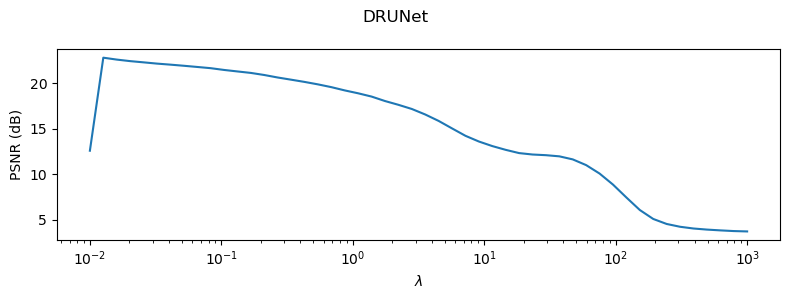

100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


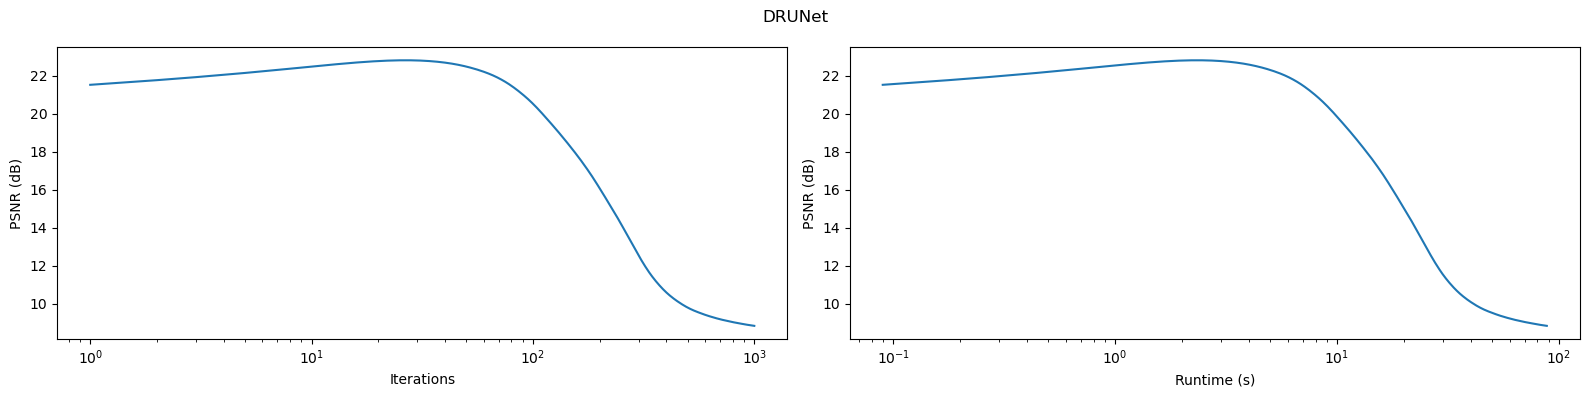

In [162]:
eps_stop = 1e-5
denoiser_name = "DRUNet"

denoiser = DENOISERS[denoiser_name]
net = denoiser["net"]
model = "drunet"
model_type = denoiser["model"]

lambda_list = np.logspace(np.log10(1e3), np.log10(1e-2), n_lambda)
n_iter_per_lambda = 200

n_lambda = len(lambda_list)
if lambda_list is None:
    lambda_list = [0.5 * std_noise] * n_lambda

x_n = Phi_channels(x_observed, Phit)
best_x_psnr = x_n.copy()
best_x_error = x_n.copy()
best_psnr = 0
best_error = 0
best_lambda = 0

cvg = [1e10] * n_lambda*n_iter_per_lambda
psnr = [0] * n_lambda
error = [0] * n_lambda
psnr_inner = [0] * n_lambda*n_iter_per_lambda
error_inner = [0] * n_lambda*n_iter_per_lambda
runtime = [0] * n_lambda*n_iter_per_lambda
stops = [0] * (n_lambda+1)

current_dual = None
current_dual_fast = None

best_current_dual, best_current_dual_fast = None, None

t_iter = 0

i = 0
for k in tqdm(range(n_lambda)):
    if not warm_restart:
        x_n = Phi_channels(x_observed, Phit)
        current_dual = None
        current_dual_fast = None
    
    for t in range(n_iter_per_lambda):
        t_start = time.perf_counter()
        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        x_old = x_n.copy()

        x_n, current_dual = apply_model(
            model, tmp, current_dual, lambda_list[k], net, True
        )
        
        t_iter += time.perf_counter() - t_start
        cvg[i] = np.sum((x_n - x_old) ** 2)
        runtime[i] = t_iter
        psnr_inner[i] = peak_signal_noise_ratio(x_n, x_truth)
        criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            
        if eps_stop is not None and criterion < eps_stop:
            break
        i += 1
    
    stops[k+1] = i
    
    if x_truth is not None:
        psnr[k] = psnr_inner[i-1]
        error[k] = error_inner[i-1]
        if psnr[k] > best_psnr:
            best_psnr = psnr[k]
            best_x_psnr = x_n.copy()
            best_lambda = lambda_list[k]
            best_current_dual = current_dual.copy() if current_dual is not None else None
            best_current_dual_fast = current_dual_fast.copy() if current_dual_fast is not None else None
        if error[k] < best_error:
            best_error = error[k]
            best_x_error = x_n.copy()

# Plot PSNR vs lambda and error vs lambda on 2 subplots
plt.figure(figsize=(8, 3))
plt.semilogx(lambda_list, psnr)
plt.xlabel(r"$\lambda$")
plt.ylabel("PSNR (dB)")
plt.suptitle(f"{denoiser_name}")
plt.tight_layout()
plt.show()

x_n = Phi_channels(x_observed, Phit)
current_dual = None
current_dual_fast = None

iter_final = 1000
error_final = [0] * iter_final
psnr_final = [0] * iter_final
best_psnr = 0
runtime_final = [0] * iter_final
cvg_final = [0] * iter_final
t_iter = 0
update_dual = True

for t in tqdm(range(iter_final)):
    
    t_start = time.perf_counter()

    g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
    tmp = x_n - gamma * g_n
    
    x_old = x_n.copy()
    x_n, current_dual = apply_model(
            model, tmp, current_dual, best_lambda, net, update_dual
        )

    t_iter += time.perf_counter() - t_start
    runtime_final[t] = t_iter
    cvg_final[t] = np.sum((x_n - x_old) ** 2)
    psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
    
    if psnr_final[t] > best_psnr:
        best_x = x_n.copy()
        best_psnr = psnr_final[t]

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.semilogx(np.arange(1, iter_final + 1), psnr_final)
plt.xlabel("Iterations")
plt.ylabel("PSNR (dB)")

plt.subplot(1, 2, 2)
plt.semilogx(runtime_final, psnr_final)
plt.xlabel("Runtime (s)")
plt.ylabel("PSNR (dB)")

plt.suptitle(f"{denoiser_name}")
plt.tight_layout()
plt.show()

100%|██████████| 5/5 [07:20<00:00, 88.19s/it]


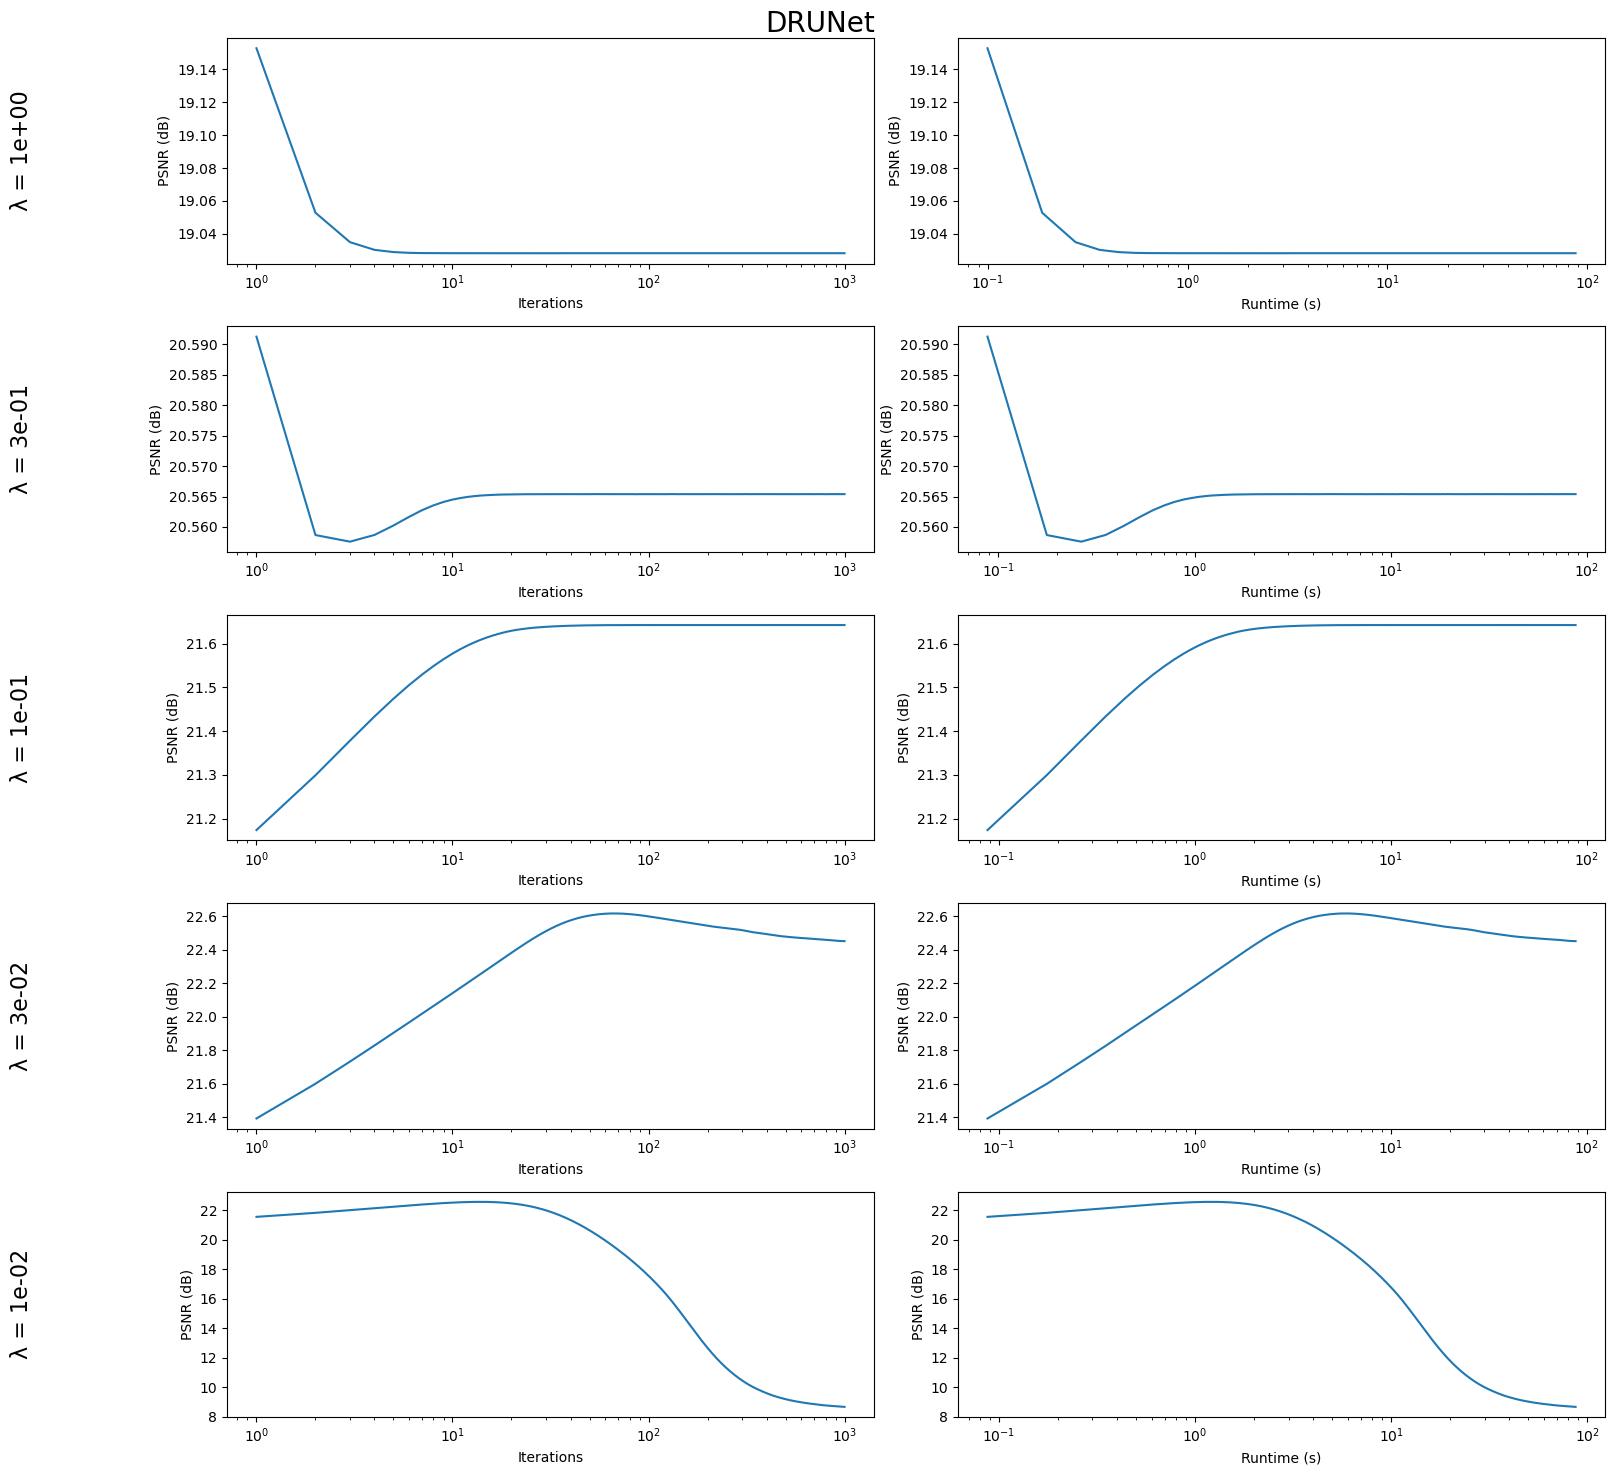

In [165]:
denoiser = DENOISERS[denoiser_name]
net = denoiser["net"]
model = "drunet"

lambdas = [1, 3e-1, 1e-1, 3e-2, 1e-2]
n = len(lambdas)
plt.figure(figsize=(16, 3*n))
i = 0

for best_lambda in tqdm(lambdas):
    
    x_n = Phi_channels(x_observed, Phit)
    current_dual = None
    current_dual_fast = None

    iter_final = 1000
    error_final = [0] * iter_final
    psnr_final = [0] * iter_final
    best_psnr = 0
    runtime_final = [0] * iter_final
    cvg_final = [0] * iter_final
    t_iter = 0
    update_dual = True

    for t in range(iter_final):
        
        t_start = time.perf_counter()

        g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
        tmp = x_n - gamma * g_n
        
        
        x_old = x_n.copy()
        x_n, current_dual = apply_model(
                model, tmp, current_dual, best_lambda, net, update_dual
            )

        t_iter += time.perf_counter() - t_start
        runtime_final[t] = t_iter
        cvg_final[t] = np.sum((x_n - x_old) ** 2)
        psnr_final[t] = peak_signal_noise_ratio(x_n, x_truth)
        
        if psnr_final[t] > best_psnr:
            best_x = x_n.copy()
            best_psnr = psnr_final[t]

    x_n = Phi_channels(x_observed, Phit)
    current_dual = None
    current_dual_fast = None

    error_final_ista = [0] * iter_final
    psnr_final_ista = [0] * iter_final
    best_psnr_ista = 0
    runtime_final_ista = [0] * iter_final
    cvg_final_ista = [0] * iter_final
    t_iter = 0
    update_dual = True
    
    plt.subplot(n, 2, 2*i+1)
    
    plt.text(-0.3, 0.5, f"λ = {best_lambda:.0e}", fontsize=16,
                transform=plt.gca().transAxes, rotation=90,
                verticalalignment='center', horizontalalignment='right')
    
    plt.semilogx(np.arange(1, iter_final + 1), psnr_final)
    plt.xlabel("Iterations")
    plt.ylabel("PSNR (dB)")

    plt.subplot(n, 2, 2*i+2)
    plt.semilogx(runtime_final, psnr_final)
    plt.xlabel("Runtime (s)")
    plt.ylabel("PSNR (dB)")
    i += 1

plt.suptitle(f"{denoiser_name}", fontsize=20)
plt.tight_layout()
plt.show()